In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import numpy as np
import scipy
import glob
import sys
from scipy import io
import math
from skimage import transform
import random
import keras
from sklearn import preprocessing
import tqdm
from sklearn.preprocessing import OneHotEncoder
from keras.utils import plot_model
import itertools
from sklearn.metrics import confusion_matrix


import matplotlib
matplotlib.rcParams['figure.figsize'] = [12, 12]
plt.style.use('ggplot')

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# GLOBALS

In [2]:
POET_DIR = "D:/data/POETdataset/"
pascal_images = os.path.join(POET_DIR, 'PascalImages')
CLASS2IDX_FILE = os.path.join(POET_DIR, 'class2idx.npy')
IDX2CLASS_FILE = os.path.join(POET_DIR, 'idx2class.npy')
PATCH_SIZE = None
HALF_PATCH = None
DATASET_SIZE = 6270
VALIDATION_PERC = 0.2
# MAX_GAZE_POINTS = 3 # TEMPORARY
MIN_GAZE_POINTS = 2
BATCH_SIZE = 50
os.chdir(POET_DIR)

# PATCH EXTRACTION 

patch size =  70


  0%|                                                                                                                                                        | 0/6131 [00:00<?, ?it/s]C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6131/6131 [01:15<00:00, 81.41it/s]


shapes: 
(5517, 5, 2048) (5517, 10) (614, 5, 2048) (614, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                266368    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 266,698
Trainable params: 266,698
Non-trainable params: 0
_________________________________________________________________
None
Train on 5517 samples, validate on 614 samples
Epoch 1/50
5517/5517 [==============================] - 5s 873us/step - loss: 1.6863 - acc: 0.4189 - val_loss: 1.0824 - val_acc: 0.6531

Epoch 00001: val_acc improved from -inf to 0.65309, saving model to 2-70\weights.hdf5
Epoch 2/50
5517/5517 [==============================] - 3s 538us/step - loss: 1.0477 - acc: 0.6538 - val_loss: 0.8228 - val_acc: 0.7150

Epoch 00002: val_acc improved from 0.65309 to 0.71498, savi

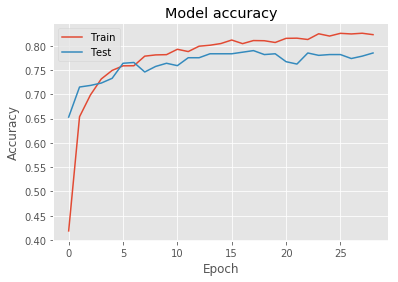

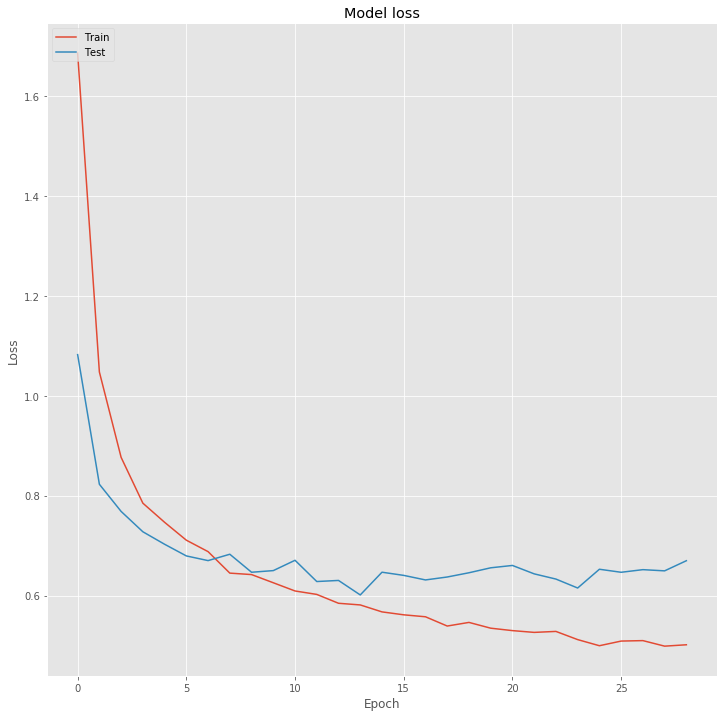

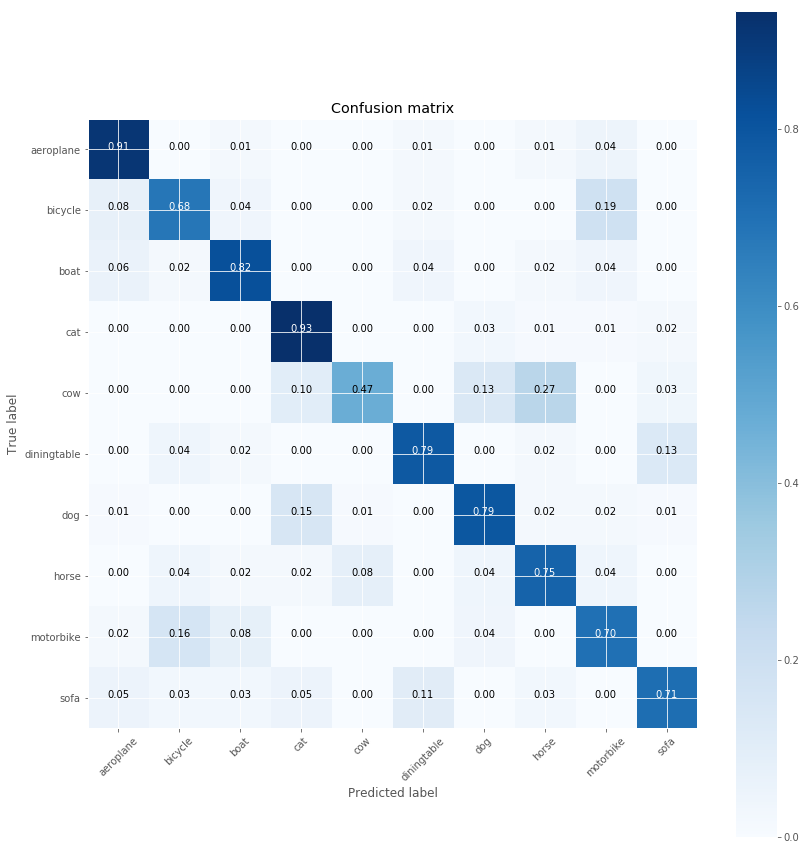

<Figure size 864x864 with 0 Axes>

In [3]:
classes = [a.split("_")[1].split(".mat")[0] for a in glob.glob("etData/*")]
idx2class = {i:c for i, c in enumerate(classes)}
class2idx = {c:i for i, c in enumerate(classes)}

def fixation_within_image(fx, fy, dims):
#   print(dims)
  if fx < 0:
    return False
  if fx > dims[1]:
    return False
  if fy < 0:
    return False
  if fy > dims[0]:
    return False

  return True

def get_avg_fixations(fixR, fixL, dims):
    # ger average of fixations between right and left eye
    # manage nans
    fix = []
    for i in range(len(fixR)):
        fR = fixR[i]
        fL = fixL[i]
        fx = None
        fy = None
        # no fixations outside
        if not np.isnan(fR[0]) and not np.isnan(fL[0]):
            fx = np.mean([fR[0],fL[0]])
        else:
            if np.isnan(fR[0]):
                fx = fL[0]
            elif np.isnan(fL[0]):
                fx = fR[0]
                
        if not np.isnan(fR[1]) and not np.isnan(fL[1]):
            fy = np.mean([fR[1],fL[1]])
        else:
            if np.isnan(fR[1]):
                fy = fL[1]
            elif np.isnan(fL[1]):
                fy = fR[1]
        if fixation_within_image(fx, fy, dims):
            fix.append([fx,fy])

    fix = np.array(fix)
    return fix

class_matrices = {}

def get_fixations(filename, classname, dims):
    filename = filename.split("%s_" %classname)[1]
    filename = filename.split('.')[0]
    if classname not in class_matrices.keys():
        c_instances = io.loadmat(os.path.join(POET_DIR,'etData','etData_%s.mat' %classname), squeeze_me=True)['etData']
        class_matrices[classname] = c_instances
    else:
        c_instances = class_matrices[classname]

    for i in c_instances:
        if filename == i['filename']:
            # get fastest user with at least X fixations
            sorted_indexes = np.argsort(i['rt'])
            for u_i in sorted_indexes:
                fixR = i['fixations'][u_i]['imgCoord']['fixR'].tolist()['pos'].tolist().tolist()
                fixL = i['fixations'][u_i]['imgCoord']['fixL'].tolist()['pos'].tolist().tolist()
                if len(fixR) > 0 and len(fixL) > 0:
                    if type(fixR[0]) is list and type(fixL[0]) is list:
                        fix = get_avg_fixations(fixR, fixL, dims)
                        if len(fix) >= MIN_GAZE_POINTS:
                            return fix

def gen_patches(filename, classname):
    img_src = keras.preprocessing.image.img_to_array(
        keras.preprocessing.image.load_img(filename)
    )

    img = np.zeros((img_src.shape[0]+PATCH_SIZE, img_src.shape[1]+PATCH_SIZE, 3), dtype=float)
    img[HALF_PATCH:HALF_PATCH+img_src.shape[0],HALF_PATCH:img_src.shape[1]+HALF_PATCH] = img_src

    fix = get_fixations(filename, classname, (img_src.shape[0], img_src.shape[1]))
    if fix is None:
        return None

    patches = []

    for i, f in enumerate(fix):
        fx = math.floor(f[0]) + HALF_PATCH # to account for paddings
        fy = math.floor(f[1]) + HALF_PATCH
        p = img[fy-HALF_PATCH:fy+HALF_PATCH,fx-HALF_PATCH:fx+HALF_PATCH]
        p = transform.resize(p, (PATCH_SIZE, PATCH_SIZE, 3))
        patches.append(p)
        
    return patches

# STORE ALL PATCHES

test_ids = np.load("test_ids.pkl")
train_ids = np.load("train_ids.pkl")

filenames = [os.path.abspath(os.path.join(pascal_images, f)) for f in np.concatenate([train_ids,test_ids])]

### Duplicates

unique_ids = ["_".join(f.split("_")[1:]) for f in filenames]

len(set(unique_ids)), len(filenames)

total_instances = len(filenames)

class2idx = np.load(CLASS2IDX_FILE).tolist()

idx2class = np.load(IDX2CLASS_FILE).tolist()

# [30,40,50,60,78,90,110,130,150,170]

for size in [70]:
    global PATCH_SIZE
    global HALF_PATCH
    PATCH_SIZE = size
    HALF_PATCH = PATCH_SIZE//2
    print("patch size = ", size)
    x = []
    y = []

    dropped_list = []
    ids = []
    duplicates = 0
    max_nr_of_fixations = 0
    
    for i, fn in enumerate(tqdm.tqdm(filenames)):
        unique_fn = "_".join(fn.split("_")[1:])
        class_found = False
        if unique_fn not in ids:
            for cname in classes:
                if cname in fn:
                    class_found = True
                    patches = gen_patches(fn, cname)
                    if patches is not None and len(patches)>0:
                        if len(patches) > max_nr_of_fixations:
                            max_nr_of_fixations = len(patches)
                        x.append(patches)
                        y.append(class2idx[cname])
                        ids.append(unique_fn)
        else:
            duplicates += 1

    duplicates + len(dropped_list) + len(x)

    assert len(x) == len(y)

    # Pad list of patches with zeros up until max
    ### We choose max_nr_fixations = 5

    MAX_PATCHES = 5

    for i in range(len(x)):
        entry = np.array(x[i],dtype=np.float32)
        if entry.shape[0] < MAX_PATCHES:
            nr_extra = MAX_PATCHES - entry.shape[0]
            empty_patches = np.zeros((nr_extra, PATCH_SIZE, PATCH_SIZE, 3),dtype=np.float32)
            x[i] = np.concatenate([empty_patches, entry])
        if entry.shape[0] > MAX_PATCHES:
            entry = entry[:5]
            entry = np.array(entry,dtype=np.float32)
            x[i] = entry
        x[i] = np.array(x[i],dtype=np.float32)


    x = np.array(x,dtype=np.float32)

    # Extract features for patches

    learned_model = keras.applications.ResNet50(weights='imagenet', include_top=False, pooling='max')
    pp_func = keras.applications.resnet50.preprocess_input

    features_extractor_model = keras.models.Sequential()
    features_extractor_model.add(keras.layers.Lambda(pp_func,name='preprocessing',input_shape=(PATCH_SIZE,PATCH_SIZE,3)))
    features_extractor_model.add(learned_model)

    x = x.reshape((x.shape[0]*MAX_PATCHES,PATCH_SIZE,PATCH_SIZE,3))

    x = features_extractor_model.predict(x)

    x = x.reshape((x.shape[0]//MAX_PATCHES,MAX_PATCHES,x.shape[1]))


    ## ONE HOT ENCODER
    enc = OneHotEncoder(handle_unknown='ignore')

    y = np.array(y)

    y = y.reshape((-1,1))

    y = enc.fit(y).transform(y)

    idx2class[y[222].argmax()], [f for f in filenames if ids[222] in f ]

    # SPLIT ACCORDING TO INDEXES

    X_train, y_train, X_test, y_test = x[:len(train_ids)], y[:len(train_ids)], x[len(train_ids):], y[len(train_ids):]

    print("shapes: ")
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    assert X_train.shape[0] + X_test.shape[0] == len(test_ids) + len(train_ids)

    ## MODEL DEFINITION

    def get_model():
        model = keras.Sequential()
        model.add(keras.layers.LSTM(32, dropout=0.7, input_shape=(MAX_PATCHES, X_train.shape[2],)))
        model.add(keras.layers.Dense(len(idx2class), activation='softmax'))

        model.compile(loss='categorical_crossentropy',
                    optimizer=keras.optimizers.Adam(),
                    metrics=['accuracy'])
        print(model.summary())
        return model

    model_id = "%s-%s" %(MIN_GAZE_POINTS, PATCH_SIZE)
    os.mkdir(model_id)

    filepath=os.path.join(model_id,"weights.hdf5")
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=15,
                              verbose=0, mode='auto')

    model = get_model()
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_test, y_test),
        verbose=1,
    #     batch_size=64,
        epochs=50,
        callbacks=[checkpoint, early_stopping]
    )

    model.load_weights(filepath)
    total_summary=""

    def add_to_summary(line):
        global total_summary
        total_summary += "%s\n" %line

    def savesummary():
        global total_summary
        path = os.path.join(model_id, "summary.txt")
        with open(path,'w') as f:
            f.writelines(total_summary)
            f.writelines("\nBest acc : %s" %np.max(history.history['val_acc']))
        print('saving summary to ', path)

    model.summary(print_fn=add_to_summary)
    savesummary()

    os.rename(model_id, "%s-acc %.4f" %(model_id, np.max(history.history['val_acc'])))

    model_id = "%s-acc %.4f" %(model_id, np.max(history.history['val_acc']))

    # Plot model history

    # Plot training & validation accuracy values
    plt.clf()
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.figure(figsize=(12,12))
    plt.gcf().savefig(os.path.join(model_id, "accuracy.png"))
    
    plt.clf()
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.figure(figsize=(12,12))
    plt.savefig(os.path.join(model_id, "loss.png"))
    
    np.save(os.path.join(model_id, "history"),history)

    # Confusion matrix

    def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

    #     print(cm)
        plt.clf()
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.figure(figsize=(12,12))
        return plt.gcf()


    y_pred_proba = model.predict(X_test)

    y_pred = np.argmax(y_pred_proba, axis=1)

    y_test_argmax = np.argmax(y_test, axis=1)

    cnf_matrix = confusion_matrix(y_test_argmax, y_pred)


    fig = plot_confusion_matrix(cnf_matrix, class2idx.keys(), normalize=True)

    np.save(os.path.join(model_id, 'model-cnf_matrix'), cnf_matrix)
    fig.savefig(os.path.join(model_id, 'model-cnf_matrix.png'))